## Installations needed for Erda to work

In [18]:
!pip install -U pip tensorflow tensorboard mediapipe tensorflow plotly scikeras tensorrt scikeras

  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)


In [66]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


# Used to create training and testing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Used for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
import keras
#Used for parameter tuning
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#For accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [20]:
os.getcwd()

'/home/jovyan/work/Test/src'

# 1. Importing and Splitting Data

In [41]:
X = np.load('../export_data/X_data.npy')
y = np.load('../export_data/y_data.npy')


In [42]:
print(X.shape)

(221, 151, 258)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=6*y.shape[1], stratify=y, random_state=40)
X.shape


(221, 151, 258)

In [24]:
for i in range (y_train.shape[1]):
    print("Number of words in " + str(i) + " category: " + str(np.count_nonzero(y_test[:,i])))

Number of words in 0 category: 5
Number of words in 1 category: 5
Number of words in 2 category: 6
Number of words in 3 category: 6
Number of words in 4 category: 6
Number of words in 5 category: 6
Number of words in 6 category: 8
Number of words in 7 category: 7
Number of words in 8 category: 5


# 2. Neural Network Implementation

### Saving Logs

In [67]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### LSTM Implementation

In [ ]:
def create_model(neurons):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='relu', input_shape=(151,258)))
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
model = KerasClassifier(model=create_model, verbose=0)


In [ ]:
# define the grid search parameters
neurons = [8, 16, 32, 64]
learn_rate = [0.001, 0.01, 0.1]
epochs = [50, 100]
param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learn_rate, epochs=epochs)
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

search.fit(X_train, y_train)

In [ ]:
search.best_score_


In [ ]:
search.best_params_


In [78]:

model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(151,258)))
model.add(Flatten())
model.add(Dense(y.shape[1], activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs = 100, callbacks = [tracing_logs])


Epoch 1/100
6/6 [==============================] - 2s 93ms/step - loss: 2.2591 - categorical_accuracy: 0.2695
Epoch 2/100
6/6 [==============================] - 1s 96ms/step - loss: 1.9829 - categorical_accuracy: 0.3593
Epoch 3/100
6/6 [==============================] - 1s 95ms/step - loss: 1.7240 - categorical_accuracy: 0.4012
Epoch 4/100
6/6 [==============================] - 1s 96ms/step - loss: 1.5150 - categorical_accuracy: 0.4551
Epoch 5/100
6/6 [==============================] - 1s 98ms/step - loss: 1.2053 - categorical_accuracy: 0.5928
Epoch 6/100
6/6 [==============================] - 1s 95ms/step - loss: 0.9773 - categorical_accuracy: 0.7186
Epoch 7/100
6/6 [==============================] - 1s 93ms/step - loss: 1.1019 - categorical_accuracy: 0.6228
Epoch 8/100
6/6 [==============================] - 1s 96ms/step - loss: 0.9358 - categorical_accuracy: 0.6766
Epoch 9/100
6/6 [==============================] - 1s 94ms/step - loss: 0.7756 - categorical_accuracy: 0.7186
Epoch 10/1

# 3. Visualizing Epoch progress of NN

Train: 0.937


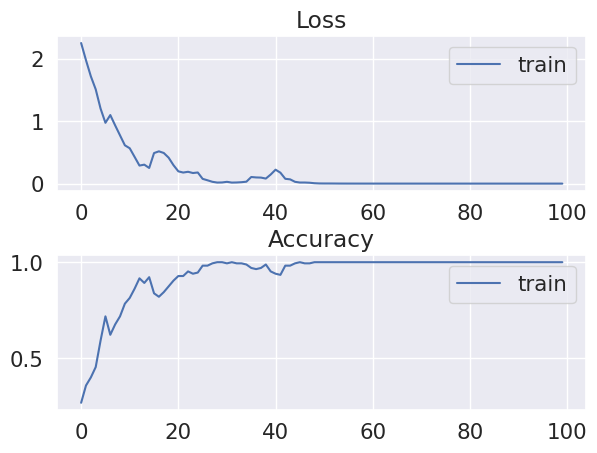

In [85]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.tight_layout(pad=1.0)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.legend()
plt.savefig('MediapipeAccuracyPlot.png')

# 3. Saving complete NN model

In [82]:
model.save('../export_data/nn_model.h5')
np.save('../export_data/X_test', X_test)
np.save('../export_data/y_test', y_test)
np.save('../export_data/X_train', X_train)
np.save('../export_data/y_train', y_train)

2/2 [==============================] - 0s 26ms/step


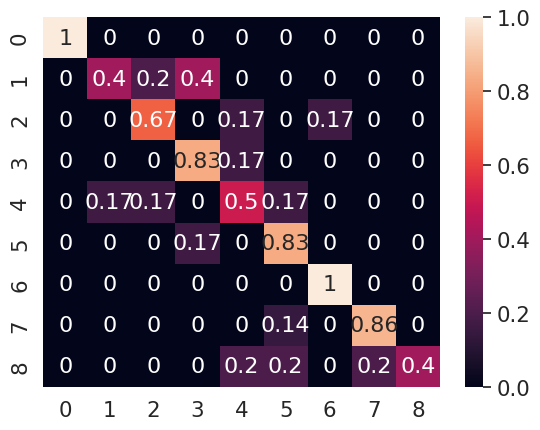

In [87]:
y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
df_cm = pd.DataFrame(conf_matrix, range(9), range(9))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()


In [81]:
accuracy_score(y_test, y_pred)

0.7407407407407407